<a href="https://colab.research.google.com/github/gkdivya/EVA/blob/main/5_CodingDrillDown/MNIST_BestModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Target:

- Added capacity (additional FC layer after GAP) to the model and added LR Scheduler



# Import Libraries

In [10]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import StepLR,OneCycleLR



## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

In [11]:
# For training set
train = datasets.MNIST('../data', train=True, download=True, #create directory and give the path, True for training set, download if dataset is not available in local storage
                    transform=transforms.Compose([
                        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.40, hue=0.1),
                        transforms.ToTensor(), # Convert image to tensor
                        transforms.Normalize((0.1307,), (0.3081,)),# Normalize image with mean and standard deviation
                        transforms.RandomRotation((-5.0, 5.0), fill=(0.1307,)),
                        ])
                    )


# For testing set
test = datasets.MNIST('../data', train=False,  # create the directory for testing dataset, train is false for testing 
                   transform=transforms.Compose([ 
                        transforms.ToTensor(), # Convert image to tensor
                        transforms.Normalize((0.1307,), (0.3081,)) # Normalize the data
                        ])
                   )


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [12]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model


In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        drop = 0.025  # droput value
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(drop)
        ) # output_size = 26    RF:  2

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),  
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(drop)
        ) # output_size = 24 RF: 5

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12    RF:  6

        # TRANSITION BLOCK 1
        self.trans1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU()
        ) # output_size = 12    RF:  6

        # CONVOLUTION BLOCK 2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), # output_size = 10    RF:  10
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), # output_size = 8    RF: 14
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=0, bias=False), # output_size = 6    RF: 18
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.Dropout(drop)
        ) 
        
        # Global average pooling
        self.gap = nn.Sequential(
            nn.AvgPool2d(6)  # output_size = 1    RF:  28
        )

        # Fully connected layer
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=16, kernel_size=(1, 1), padding=0, bias=False), # output_size = 1    RF: 28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),  # output  RF: 28
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.trans1(x)
        x = self.convblock3(x)
        x = self.gap(x)
        x = self.convblock5(x)
        x = x.view(-1, 10)   # convert 2D to 1D
        
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [14]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
       BatchNorm2d-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
      BatchNorm2d-11            [-1, 8, 12, 12]              16
             ReLU-12            [-1, 8, 12, 12]               0
           Conv2d-13           [-1, 12, 10, 10]             864
      BatchNorm2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [15]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch 
    # accumulates the gradients on subsequent backward passes. Because of this, when you start your training loop, 
    # ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update LR
    scheduler.step()
    
    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Batch_id={batch_idx} Loss={loss.item():.5f} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_losses.append(test_loss)
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [16]:
model =  Net().to(device)
NUM_EPOCHS = 15
optimizer = optim.SGD(model.parameters(), lr=0.017, momentum=0.9)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.017, epochs=NUM_EPOCHS, steps_per_epoch=len(train_loader))

for epoch in range(1,NUM_EPOCHS+1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

    

EPOCH: 1


Batch_id=468 Loss=0.29607 Accuracy=70.08: 100%|██████████| 469/469 [00:53<00:00,  8.80it/s]



Test set: Average loss: 0.2511, Accuracy: 9612/10000 (96.12%)

EPOCH: 2


Batch_id=468 Loss=0.14628 Accuracy=95.54: 100%|██████████| 469/469 [00:53<00:00,  8.73it/s]



Test set: Average loss: 0.0785, Accuracy: 9786/10000 (97.86%)

EPOCH: 3


Batch_id=468 Loss=0.04647 Accuracy=97.11: 100%|██████████| 469/469 [00:53<00:00,  8.71it/s]



Test set: Average loss: 0.0556, Accuracy: 9837/10000 (98.37%)

EPOCH: 4


Batch_id=468 Loss=0.04252 Accuracy=97.72: 100%|██████████| 469/469 [00:53<00:00,  8.77it/s]



Test set: Average loss: 0.0493, Accuracy: 9851/10000 (98.51%)

EPOCH: 5


Batch_id=468 Loss=0.03376 Accuracy=98.14: 100%|██████████| 469/469 [00:53<00:00,  8.79it/s]



Test set: Average loss: 0.0369, Accuracy: 9892/10000 (98.92%)

EPOCH: 6


Batch_id=468 Loss=0.03412 Accuracy=98.38: 100%|██████████| 469/469 [00:54<00:00,  8.55it/s]



Test set: Average loss: 0.0304, Accuracy: 9902/10000 (99.02%)

EPOCH: 7


Batch_id=468 Loss=0.03012 Accuracy=98.48: 100%|██████████| 469/469 [00:54<00:00,  8.62it/s]



Test set: Average loss: 0.0286, Accuracy: 9912/10000 (99.12%)

EPOCH: 8


Batch_id=468 Loss=0.01021 Accuracy=98.68: 100%|██████████| 469/469 [00:52<00:00,  8.86it/s]



Test set: Average loss: 0.0304, Accuracy: 9909/10000 (99.09%)

EPOCH: 9


Batch_id=468 Loss=0.20190 Accuracy=98.75: 100%|██████████| 469/469 [00:53<00:00,  8.71it/s]



Test set: Average loss: 0.0251, Accuracy: 9921/10000 (99.21%)

EPOCH: 10


Batch_id=468 Loss=0.08117 Accuracy=98.80: 100%|██████████| 469/469 [00:52<00:00,  8.88it/s]



Test set: Average loss: 0.0223, Accuracy: 9930/10000 (99.30%)

EPOCH: 11


Batch_id=468 Loss=0.05942 Accuracy=98.88: 100%|██████████| 469/469 [00:53<00:00,  8.70it/s]



Test set: Average loss: 0.0217, Accuracy: 9939/10000 (99.39%)

EPOCH: 12


Batch_id=468 Loss=0.01466 Accuracy=99.00: 100%|██████████| 469/469 [00:53<00:00,  8.71it/s]



Test set: Average loss: 0.0195, Accuracy: 9940/10000 (99.40%)

EPOCH: 13


Batch_id=468 Loss=0.03093 Accuracy=99.04: 100%|██████████| 469/469 [00:52<00:00,  8.90it/s]



Test set: Average loss: 0.0188, Accuracy: 9946/10000 (99.46%)

EPOCH: 14


Batch_id=468 Loss=0.03084 Accuracy=99.17: 100%|██████████| 469/469 [00:54<00:00,  8.64it/s]



Test set: Average loss: 0.0183, Accuracy: 9942/10000 (99.42%)

EPOCH: 15


Batch_id=468 Loss=0.03181 Accuracy=99.27: 100%|██████████| 469/469 [00:53<00:00,  8.79it/s]



Test set: Average loss: 0.0187, Accuracy: 9941/10000 (99.41%)



Text(0.5, 1.0, 'Test Accuracy')

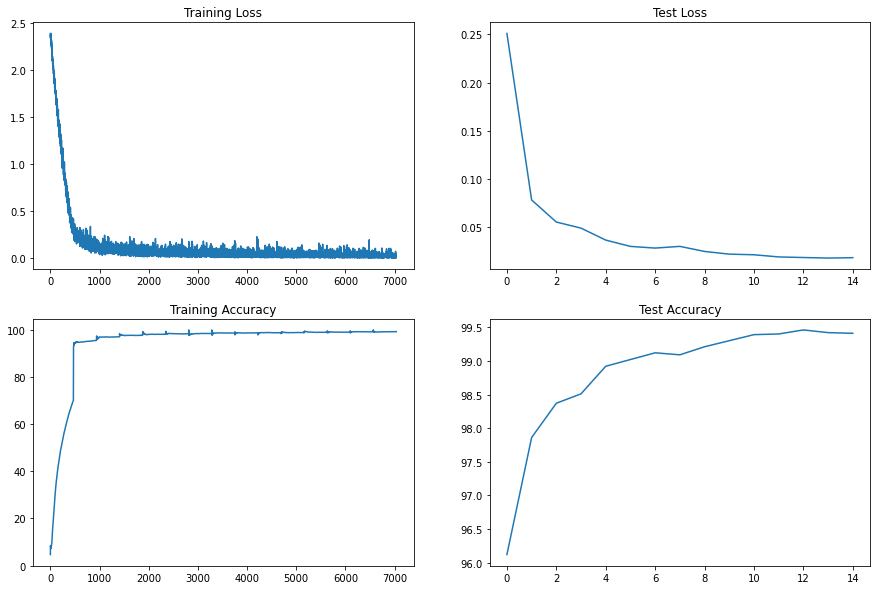

In [17]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Results:
- Parameters: 7496
- Best Training Accuracy: 99.27
- Best Test Accuracy: 99.46

## Analysis:

- The model parameters have increased
- The model is under-fitting. This is fine, as we know we have made our train data harder.  
- LR Scheduler and the additional capacity after GAP helped getting to the desired target 99.4, Onecyclic LR is being used, this seemed to have achieve consistent accuracy in last few layers